# 1. Initial set-up

In [1]:
!pip install kafka-python --quiet
!wget --quiet https://downloads.apache.org/kafka/3.9.0/kafka_2.13-3.9.0.tgz
!tar -xzf kafka_2.13-3.9.0.tgz --strip-components=1

In [2]:
!pip install river --quiet
#!pip install river==0.10.1

In [3]:
!wget --quiet https://github.com/diratche/datastream/raw/refs/heads/main/2024-01-01-2025-01-22-Russia-Ukraine.tar.gz
!tar -xzf 2024-01-01-2025-01-22-Russia-Ukraine.tar.gz

In [4]:
!wget --quiet https://github.com/diratche/datastream/raw/refs/heads/main/ingest.py

In [5]:
import time
from os.path import exists
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
from kafka import KafkaConsumer
from river import preprocessing, dummy, stats
from sklearn.linear_model import LinearRegression

In [6]:
my_key = '33d95511a13a41b886e141256252001'

In [7]:
max_instances = 1825    # 5 oblasts * 365 days = 1825 instances. We don't want to feed the same instance twice to our models.

# 2. Ingesting the data with Kafka

In [8]:
!nohup bin/zookeeper-server-start.sh config/zookeeper.properties > zookeeper.out &
while not exists('zookeeper.out'):
    pass

nohup: redirecting stderr to stdout


In [9]:
!nohup bin/kafka-server-start.sh config/server.properties > kafka.out &
while not exists('kafka.out'):
    pass

nohup: redirecting stderr to stdout


In [10]:
!bin/kafka-topics.sh --create --topic data-ingestion --bootstrap-server localhost:9092 --partitions 2

Error while executing topic command : Topic 'data-ingestion' already exists.
[2025-01-23 10:31:26,102] ERROR org.apache.kafka.common.errors.TopicExistsException: Topic 'data-ingestion' already exists.
 (org.apache.kafka.tools.TopicCommand)


In [11]:
!nohup python -u ingest.py $my_key 'data-ingestion' > ingest.out &

nohup: redirecting stderr to stdout


In [12]:
!tail ingest.out

# 3. Learning and predicting with River and CapyMOA

In [13]:
# For some reason (maybe a conflict between their respective versions of java), CapyMOA musn't be installed before the kafka topics are started.
!pip install capymoa --quiet

In [14]:
from capymoa.stream import Schema
from capymoa.instance import RegressionInstance, Instance
from capymoa.base import Regressor
from capymoa.regressor import SGDRegressor, SOKNLBT, ORTO, FIMTDD, SOKNL
from capymoa.evaluation import RegressionWindowedEvaluator
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [15]:
from capymoa.evaluation.visualization import plot_windowed_results

In [16]:
oblasts = ['Donetsk',
                'Luhansk',
                'Zaporizhzhya',
                'Kharkiv',
                'Kherson',
                ]

df = pd.read_csv('2024-01-01-2025-01-22-Russia-Ukraine.csv', on_bad_lines='warn')
df.loc[df['admin1']=='Zaporizhia', 'admin1'] = 'Zaporizhzhya'
df['datetime'] = pd.to_datetime(df['event_date'])
df = df.loc[df['event_type'].isin(['Battles'])]
df = df.loc[df['country'].isin(['Ukraine'])]
df = df.loc[df['admin1'].isin(oblasts)]
df = df[['datetime', 'admin1', 'event_type']]
totals = df.groupby('admin1').count()['event_type']

In [17]:
def stream(consumer):
    for message in consumer:
        data = message.value
        oblast = data['oblast']
        target = data['target']
        features = data['features']
        yield features, target, oblast

In [18]:
schema = Schema.from_custom(feature_names=['temperature', 'wind', 'precipitation', 'snow', 'visibility', 'moon', 'daylength',],
                                                    dataset_name="MyRegression",
                                                    target_attribute_name="target",
                                                    target_type='numeric')

In [19]:
models = {}
evaluators = {}
model_names = []

In [20]:
scaler = preprocessing.StandardScaler()

In [21]:
baseline = dummy.StatisticRegressor(stats.Mean())

In [22]:
models['SGD'] = SGDRegressor(schema)
evaluators['SGD'] = RegressionWindowedEvaluator(schema=schema, window_size=10)
model_names.append('SGD')

In [23]:
models['SOKNLBT'] = SOKNLBT(schema)
evaluators['SOKNLBT'] = RegressionWindowedEvaluator(schema=schema, window_size=10)
model_names.append('SOKNLBT')

In [24]:
models['SOKNL'] = SOKNL(schema)
evaluators['SOKNL'] = RegressionWindowedEvaluator(schema=schema, window_size=10)
model_names.append('SOKNL')

In [25]:
models['ORTO'] = ORTO(schema)
evaluators['ORTO'] = RegressionWindowedEvaluator(schema=schema, window_size=10)
model_names.append('ORTO')

In [26]:
models['FIMTDD'] = FIMTDD(schema)
evaluators['FIMTDD'] = RegressionWindowedEvaluator(schema=schema, window_size=10)
model_names.append('FIMTDD')

In [27]:
preds = pd.DataFrame(index=range(max_instances), columns=model_names, dtype=float)
preds['baseline'] = pd.Series(dtype=float)
preds['Oblast'] = pd.Series(dtype='object')
preds['Target'] = pd.Series(dtype=float)

In [28]:
consumer = KafkaConsumer('data-ingestion', bootstrap_servers='localhost:9092', group_id='instances', value_deserializer=lambda x: json.loads(x.decode('utf-8')))
id = -2
for x, y, oblast in stream(consumer):
    if id >= max_instances:
        consumer.close()
        break
    else:
        id += 1
    if id >= 0:
        preds.loc[id, 'Oblast'] = oblast
        preds.loc[id, 'Target'] = y * totals[oblast]
    scaler.learn_one(x)
    x = scaler.transform_one(x)
    baseline.learn_one(x, y)
    if id >= 0:
        y_pred = baseline.predict_one(x)
        y_pred *= totals[oblast]
        preds.loc[id, 'baseline'] = y_pred
    x = np.array(list(x.values()))
    instance = Instance.from_array(schema, x)
    reg_instance = RegressionInstance.from_array(schema, x, y)
    for model_name in model_names:
        if id >= 0:  # scikit-learn does not allows invoking predict in a model that was not fit before
            y_pred = models[model_name].predict(instance)
        models[model_name].train(reg_instance)
        if id >= 0:
            y_pred *= totals[oblast]
            y *= totals[oblast]
            evaluators[model_name].update(y, y_pred)
            preds.loc[id, model_name] = y_pred


In [29]:
# We need to kill the ingestion script to avoid consumming all the request credits on WeatherAPI:
!kill $(ps aux | grep '[i]ngest.py' | awk '{print $2}')

# 4. Interpreting the results

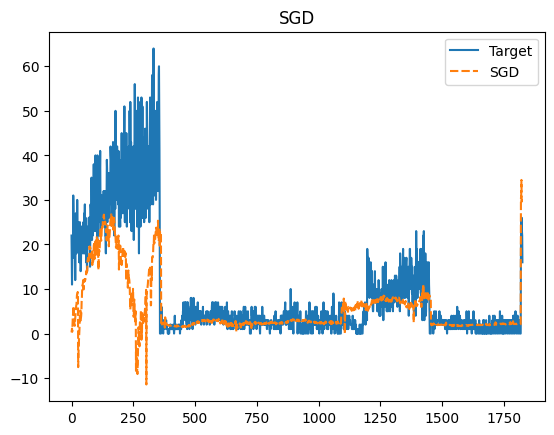

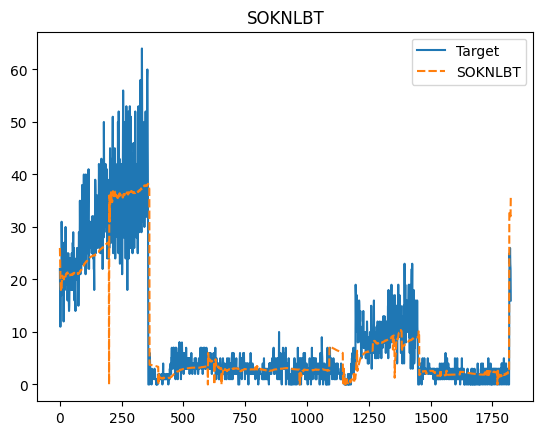

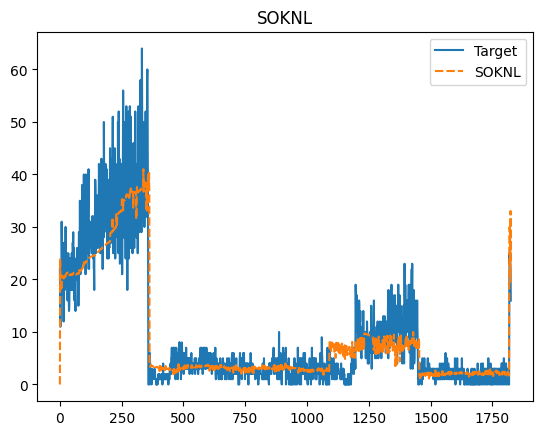

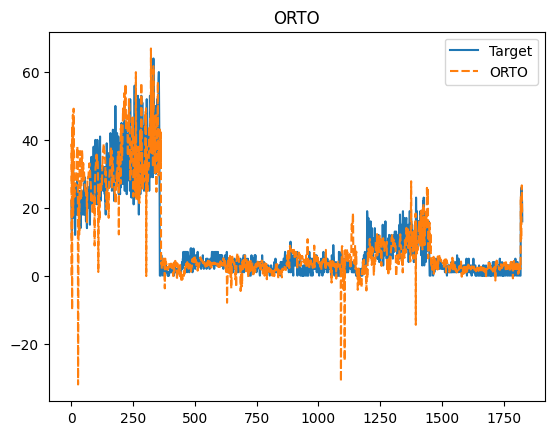

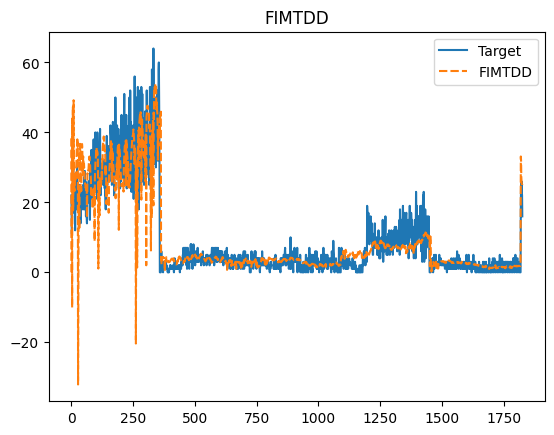

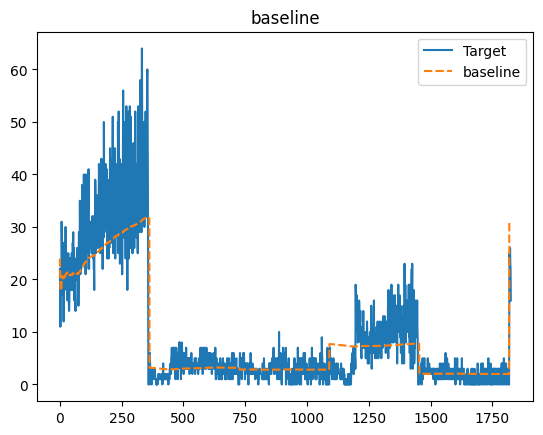

In [30]:
model_names.append('baseline')
for model_name in model_names:
    sns.lineplot(preds[['Target', model_name]])
    plt.title(model_name)
    plt.show()

In [31]:
stds = {}
for oblast in oblasts:
    stds[oblast] = df.loc[df['admin1'] == oblast].groupby('datetime').count().describe().loc['std', 'event_type']

In [32]:
aes = pd.DataFrame(index=range(max_instances))
for model_name in model_names:
    aes[model_name] = np.absolute(preds[model_name] - preds['Target'])
aes['Oblast'] = preds['Oblast']

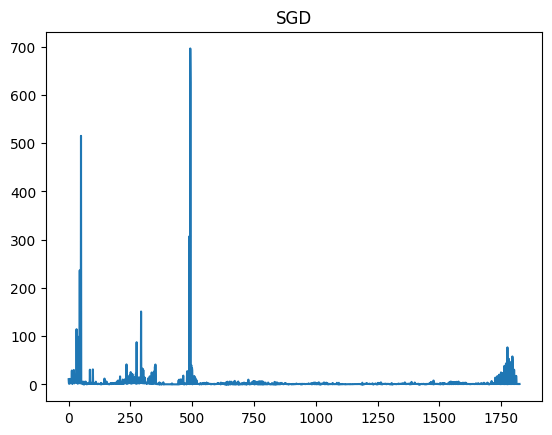

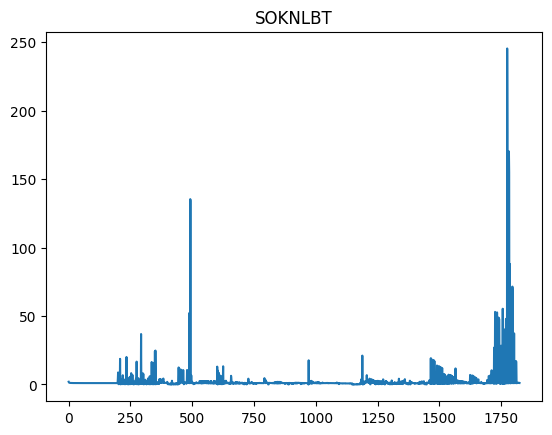

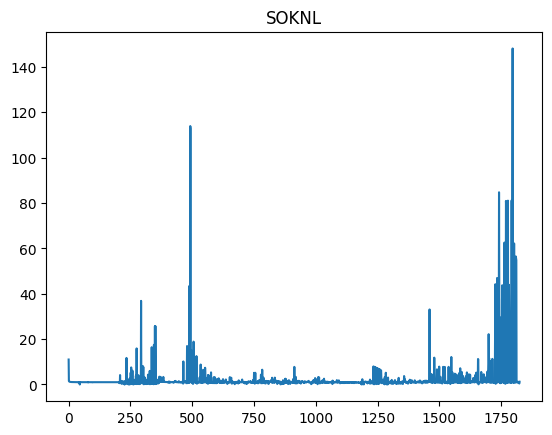

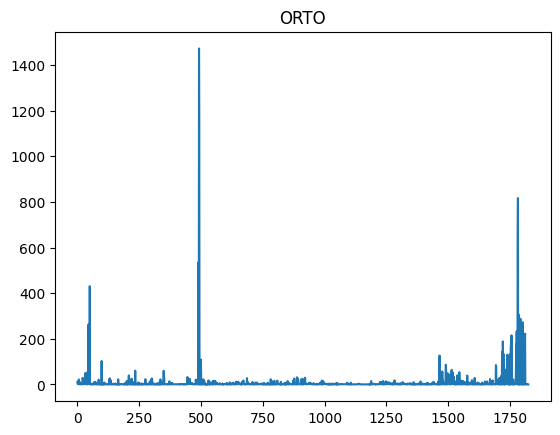

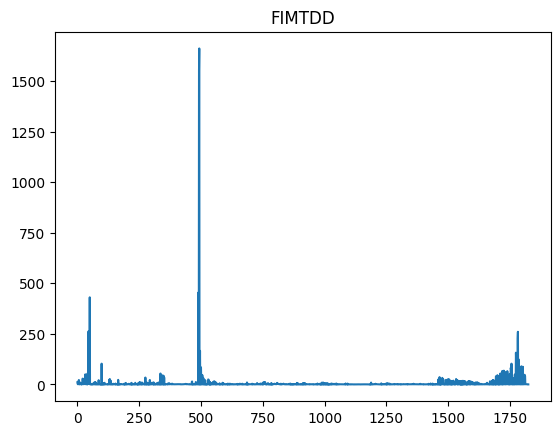

In [33]:
model_names.remove('baseline')
for model_name in model_names:
    sns.lineplot(aes[model_name] / aes['baseline'])
    plt.title(model_name)
    plt.show()

In [34]:
model_names.append('baseline')
maes = pd.DataFrame(index=oblasts, columns=model_names)
maes['std'] = pd.Series(dtype=float)
for oblast in oblasts:
    maes.loc[oblast] = aes.loc[aes['Oblast'] == oblast].drop(columns=['Oblast']).mean()
    maes.loc[oblast, 'std'] = stds[oblast]

In [35]:
# Define the gradient coloring function
def gradient_color(val, std):
    ratio = val / std  # Calculate the ratio of value to std
    if ratio < 1:
        # Green to Yellow gradient
        red = int(255 * ratio)
        green = 255
    else:
        # Yellow to Red gradient
        red = 255
        green = int(255 * (2 - ratio))  # Decrease green as ratio > 1
    red, green = max(0, min(255, red)), max(0, min(255, green))  # Clamp to [0, 255]
    return f"background-color: rgb({red}, {green}, 0); color: black;"

# Apply the gradient formatting
def highlight_gradient(row):
    std_val = row["std"]
    return [gradient_color(row[col], std_val) if col != "std" else "" for col in maes.columns]

styled_maes = maes.style.apply(highlight_gradient, axis=1)

# Display the styled DataFrame
styled_maes

,SGD,SOKNLBT,SOKNL,ORTO,FIMTDD,baseline,std
Donetsk,18.196694,6.828292,6.950015,9.418695,9.743077,7.603056,9.743351
Luhansk,1.454490,1.379907,1.458248,1.933120,1.535120,1.412589,1.698623
Zaporizhzhya,1.370086,1.405412,1.428362,1.908410,1.490834,1.372831,1.535242
Kharkiv,4.080038,3.718885,4.237222,4.726457,3.726084,4.295433,4.980020
Kherson,1.034436,1.069808,1.071927,1.409127,1.094103,1.001096,1.007500


In [36]:
styled_maes.to_html("styled_maes.html")